In [34]:
from astropy import units as u
import astropy.io.fits as fits
from astropy.coordinates import get_moon, get_sun, EarthLocation, SkyCoord
from astropy.utils.data import conf as astropy_data_conf
from astropy.table import vstack
from astropy.time import Time
from astropy.timeseries import TimeSeries, LombScargle
from astropy.stats import sigma_clip
from matplotlib import pyplot

from astroquery.vizier import Vizier
from IPython.display import display
from panoptes_client import Subject

import numpy
import pandas
import seaborn
import urllib

In [35]:
SWASP_ID = 75077900
FOLDING_PERIOD = 0 # Days. Set to 0 to run Lomb-Scargle
AUTO_FOLDED_PLOTS = 10 # How many of the top Lomb-Scargle periods to plot
PERIOD_MAX_DAYS = 600 # Max for Lomb-Scargle
PERIOD_MIN_DAYS = 1.0/24.0 # Min for Lomb-Scargle
SIGMA_CLIP = 4
FLUX_LIMIT = 1e6
START_TIME = 0 # Will be automatically overridden for BHH subjects
END_TIME = 0 # Will be automatically overridden for BHH subjects
VESPA_EXPORT = '../../superwasp-data/vespa-export.csv' # Set to None to skip loading superwasp.org FITS URLs
astropy_data_conf.remote_timeout = 300

In [36]:
if type(SWASP_ID) is int:
    subject = Subject(SWASP_ID)
    if 'wasp_id' in subject.metadata:
        SWASP_ID = subject.metadata['wasp_id']
    if '#start_tmid' in subject.metadata:
        START_TIME = subject.metadata['#start_tmid']
    if '#end_tmid' in subject.metadata:
        END_TIME = subject.metadata['#end_tmid']
SWASP_ID, START_TIME, END_TIME

('1SWASP J200947.71-371945.7', 114374319.0, 118696129.0)

In [37]:
TARGET_COORD = SkyCoord.from_name(SWASP_ID, parse=True)

In [38]:
cat_results = Vizier.query_object(SWASP_ID.split(' ')[1], catalog=['B/gcvs', 'B/vsx/vsx'])
cat_results

Empty TableList

In [39]:
for r in cat_results:
    display(r)

In [40]:
if VESPA_EXPORT is not None:
    vespa = pandas.read_csv(VESPA_EXPORT)
    fits_urls = vespa[vespa['SuperWASP ID'] == SWASP_ID.replace(' ', '')]['FITS URL'].unique()
else:
    fits_urls = []

In [41]:
if len(fits_urls) == 0:
    fits_url = 'http://wasp.warwick.ac.uk/lcextract?{}'.format(
        urllib.parse.urlencode(
            {'objid': SWASP_ID.replace('1SWASPJ', '1SWASP J')},
            quote_via=urllib.parse.quote,
        )
    )
else:
    fits_url = fits_urls[0]
fits_url

'http://wasp.warwick.ac.uk/lcextract?objid=1SWASP%20J200947.71-371945.7'

In [42]:
f2mag = lambda f: 15 - 2.5 * numpy.log10(f)
superwasp_n_location = EarthLocation.of_site("Roque de los Muchachos")
superwasp_s_location = EarthLocation.of_site("Sutherland")

superwasp_locations = {1: superwasp_n_location, 2: superwasp_s_location}
def lunar_phase(times, location):
    moon_coords = get_moon(
        time=times,
        location=location,
    )
    return (
        moon_coords.separation(get_sun(time=times)),
        moon_coords.separation(TARGET_COORD),
    )

In [43]:
fits_file = fits.open(fits_url)
hjd_col = fits.Column(name='HJD', format='D', array=fits_file[1].data['TMID'] / 86400 + 2453005.5)
lc_data = fits.BinTableHDU.from_columns(fits_file[1].data.columns + fits.ColDefs([hjd_col]))
timeseries = TimeSeries.read(lc_data, time_column='HJD', time_format='jd')

In [44]:
timeseries['location ID'] = [int(s[0]) for s in timeseries['IMAGEID']]
ts_parts = []
for id, loc in superwasp_locations.items():
    loc_ts = timeseries[timeseries['location ID'] == id]
    if len(loc_ts) == 0:
        continue
    loc_ts['lunar phase'], loc_ts['lunar separation'] = lunar_phase(loc_ts.time, loc)
    ts_parts.append(loc_ts)
timeseries = vstack(ts_parts)

In [45]:
timeseries = timeseries[timeseries['TAMFLUX2'] <= FLUX_LIMIT]
timeseries = timeseries[timeseries['TAMFLUX2'] > 0]

In [46]:
if SIGMA_CLIP > 0:
    ts_flux = sigma_clip(timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
else:
    ts_flux = timeseries['TAMFLUX2']
ts_data = {
    'time': timeseries.time.jd,
    'flux': ts_flux,
    'err': timeseries['TAMFLUX2_ERR'],
    'camera': timeseries['CAMERA_ID'],
    'lunar phase': timeseries['lunar phase'],
    'lunar separation': timeseries['lunar separation'],
}

In [47]:
def get_folded_ts(orig_ts, period):
    ts = orig_ts.fold(period=period * 86400 * u.second)
    epoch_length = ts['time'].max() - ts['time'].min()
    ts_out = [ts]
    ts_new = ts.copy()
    ts_new['time'] = ts_new['time'] + epoch_length
    ts_out.append(ts_new)
    ts = vstack(ts_out)
    if SIGMA_CLIP > 0:
        ts_flux = sigma_clip(ts['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        ts_flux = ts['TAMFLUX2']

    return {
        'time': ts.time.jd,
        'flux': ts_flux,
        'err': ts['TAMFLUX2_ERR'],
        'camera': ts['CAMERA_ID'],
        'lunar phase': ts['lunar phase'],
        'lunar separation': ts['lunar separation'],
    }

In [48]:
trimmed_timeseries = timeseries
if START_TIME > 0:
    START_TIME = Time(START_TIME / 86400 + 2453005.5, format='jd')
    trimmed_timeseries = trimmed_timeseries[trimmed_timeseries['time'] > START_TIME]
if END_TIME > 0:
    END_TIME = Time(END_TIME / 86400 + 2453005.5, format='jd')
    trimmed_timeseries = trimmed_timeseries[trimmed_timeseries['time'] < END_TIME]


c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


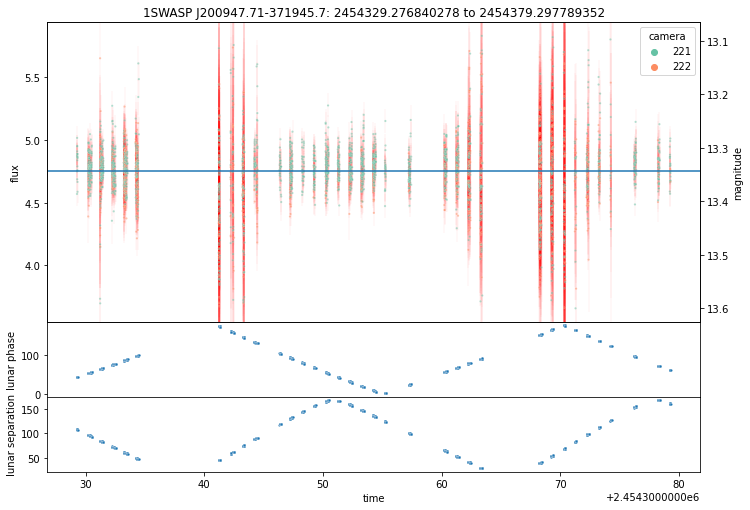

In [49]:
if trimmed_timeseries is not timeseries:
    if SIGMA_CLIP > 0:
        trimmed_ts_flux = sigma_clip(trimmed_timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        trimmed_ts_flux = trimmed_timeseries['TAMFLUX2']
    trimmed_ts_data = {
        'time': trimmed_timeseries.time.jd,
        'flux': trimmed_ts_flux,
        'err': trimmed_timeseries['TAMFLUX2_ERR'],
        'camera': trimmed_timeseries['CAMERA_ID'],
        'lunar phase': trimmed_timeseries['lunar phase'],
        'lunar separation': trimmed_timeseries['lunar separation'],
    }

    f, (main_ax, lunar_phase_ax, lunar_sep_ax) = pyplot.subplots(
        3, 1, figsize=(11.7,8.27), sharex='col', gridspec_kw={'height_ratios': (4, 1, 1)}
    )

    seaborn.scatterplot(
        data=trimmed_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
        ax=main_ax,
    )

    lims = main_ax.get_ylim()
    main_ax.axhline(numpy.median(trimmed_ts_flux))

    main_ax.errorbar(
        trimmed_ts_data['time'], trimmed_ts_data['flux'], yerr=trimmed_ts_data['err'], 
        ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1
    )

    main_ax.set_ylim(lims)
    main_ax_right = main_ax.twinx()
    try:
        main_ax_right.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
    except ValueError:
        pass
    main_ax_right.set_ylabel('magnitude')

    seaborn.scatterplot(
        data=trimmed_ts_data,
        x='time',
        y='lunar phase',
        s=5,
        palette='Set2',
        ax=lunar_phase_ax,
    )

    seaborn.scatterplot(
        data=trimmed_ts_data,
        x='time',
        y='lunar separation',
        s=5,
        palette='Set2',
        ax=lunar_sep_ax,
    )

    pyplot.subplots_adjust(hspace=.0)
    pyplot.title(f"{SWASP_ID}: {START_TIME} to {END_TIME}")

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0.5, 1.0, '1SWASP J200947.71-371945.7')

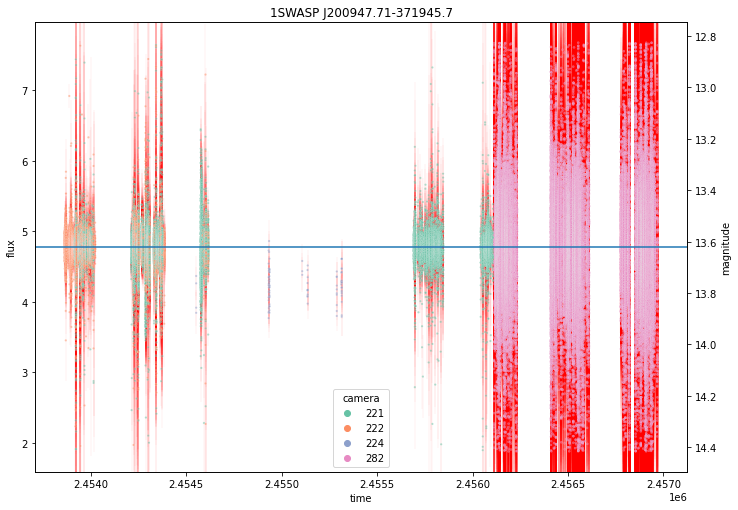

In [50]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
seaborn.scatterplot(
    data=ts_data,
    x='time',
    y='flux',
    alpha=0.5,
    s=5,
    palette='Set2',
    hue='camera',
)
lims = pyplot.ylim()
pyplot.axhline(numpy.median(ts_flux))

pyplot.errorbar(
    ts_data['time'], ts_data['flux'], yerr=ts_data['err'], 
    ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1
)

pyplot.ylim(lims)
ax2 = ax.twinx()
try:
    ax2.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
except ValueError:
    pass
ax2.set_ylabel('magnitude')
pyplot.title(SWASP_ID)

In [51]:
if FOLDING_PERIOD == 0:
    frequency, power = LombScargle(ts_data['time'], ts_data['flux'], ts_data['err']).autopower()
    periods = pandas.DataFrame({'frequency': frequency, 'power': power, 'period': 1/frequency}).sort_values('power', ascending=False)
else:
    ls = None
    periods = pandas.DataFrame({'frequency': 1, 'power': [1], 'period': FOLDING_PERIOD})
periods

frequency          power    period
265398  17.067938    5305.088330  0.058589
254955  16.396342    2775.811714  0.060989
253721  16.316983    1659.142582  0.061286
99534    6.401124    1642.389252  0.156223
267029  17.172828    1424.410349  0.058232
...           ...            ...       ...
244836  15.745583   -2979.400863  0.063510
257191  16.540141   -4185.108053  0.060459
263158  16.923882   -5208.888174  0.059088
250760  16.126559   -5652.430875  0.062010
170140  10.941838 -298329.996306  0.091392

[1343138 rows x 3 columns]

In [52]:
periods['period'] = numpy.round(periods['period'], 1)
periods = periods.drop_duplicates(subset=('period',))
periods = periods[periods['period'] <= PERIOD_MAX_DAYS ]
periods = periods[periods['period'] >= PERIOD_MIN_DAYS ]
periods

frequency        power  period
265398  17.067938  5305.088330     0.1
99534    6.401124  1642.389252     0.2
60104    3.865357   380.319930     0.3
43652    2.807319     0.324570     0.4
34309    2.206465     0.323286     0.5
...           ...          ...     ...
732      0.047108     0.225580    21.2
735      0.047300     0.172522    21.1
748      0.048136     0.151670    20.8
745      0.047944     0.059758    20.9
739      0.047558     0.058873    21.0

[762 rows x 3 columns]

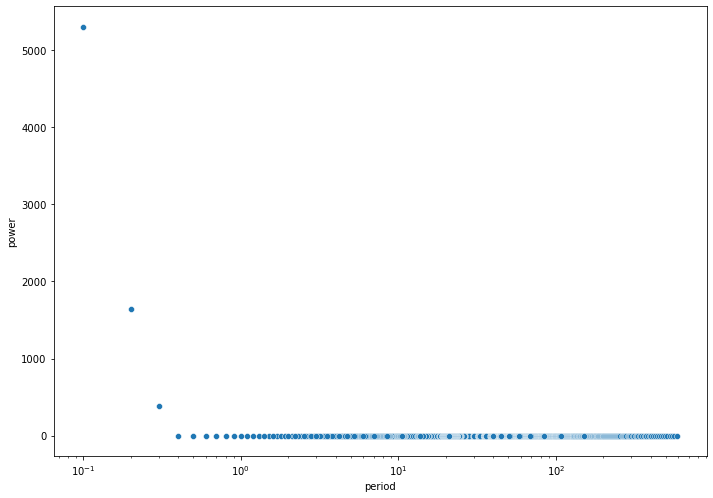

In [53]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
lsplot = seaborn.scatterplot(data=periods, x='period', y='power')
lsplot.set(xscale="log")
try:
    pyplot.show()
except ValueError:
    pass

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\anm83\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


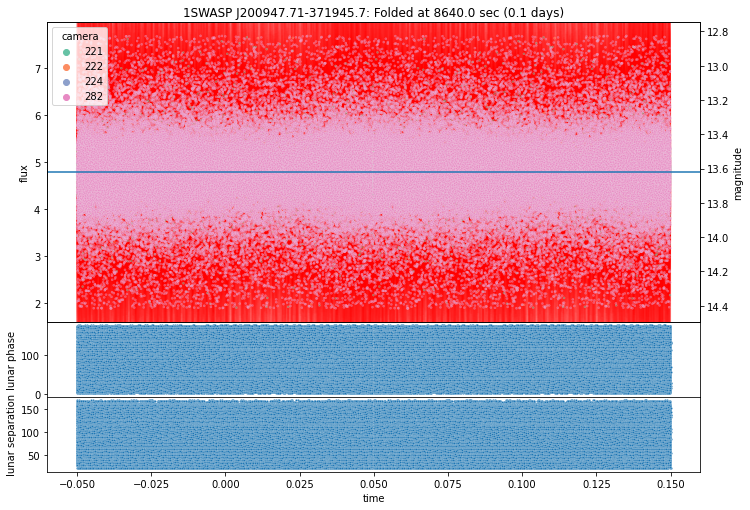

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


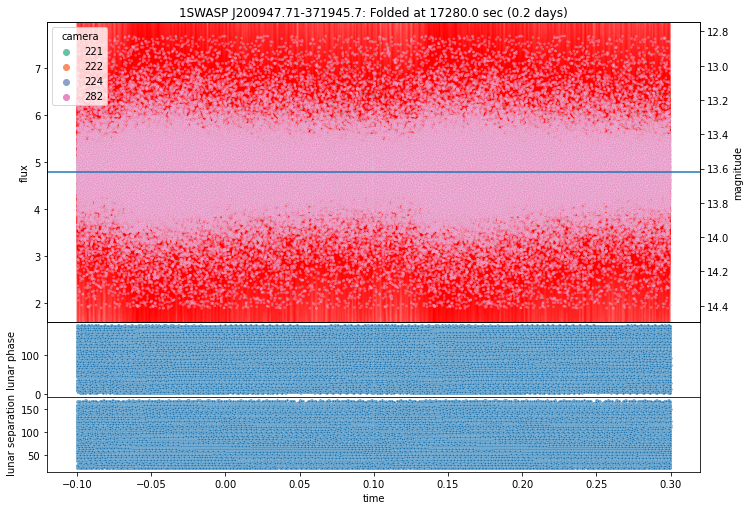

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\anm83\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


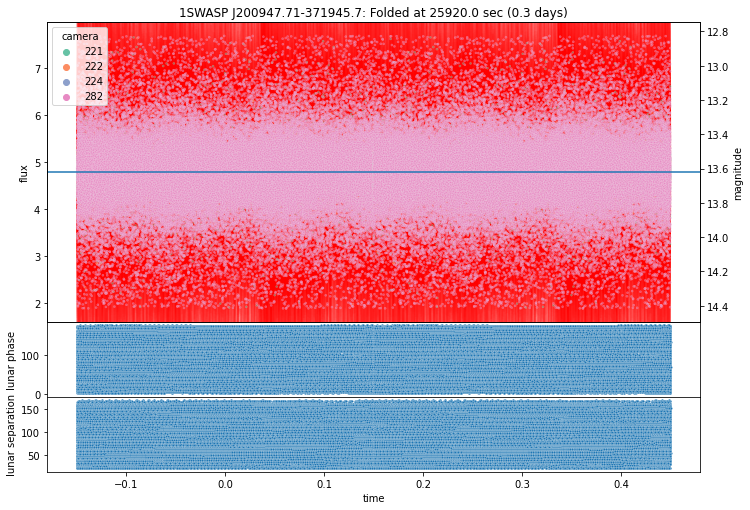

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


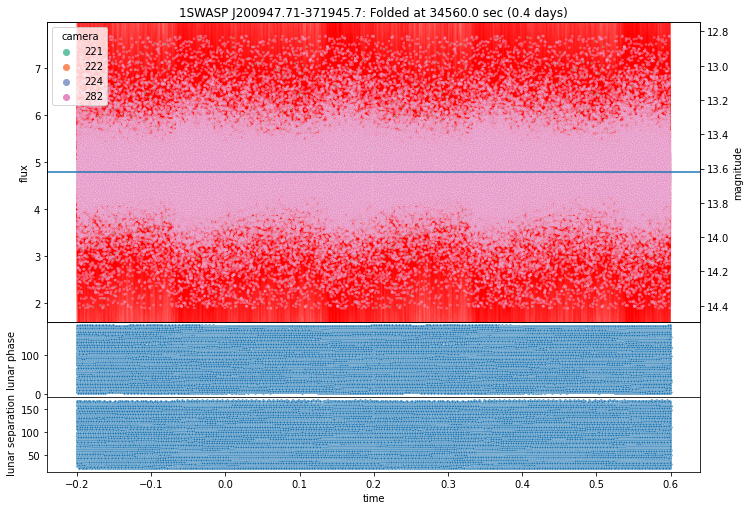

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\anm83\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


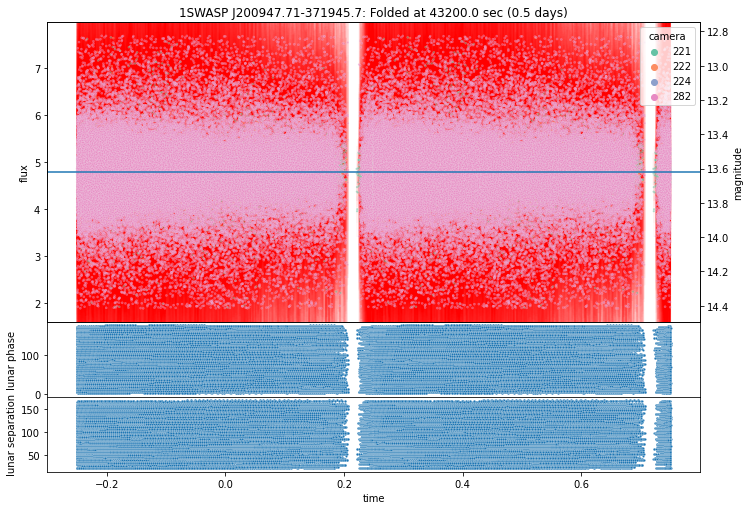

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


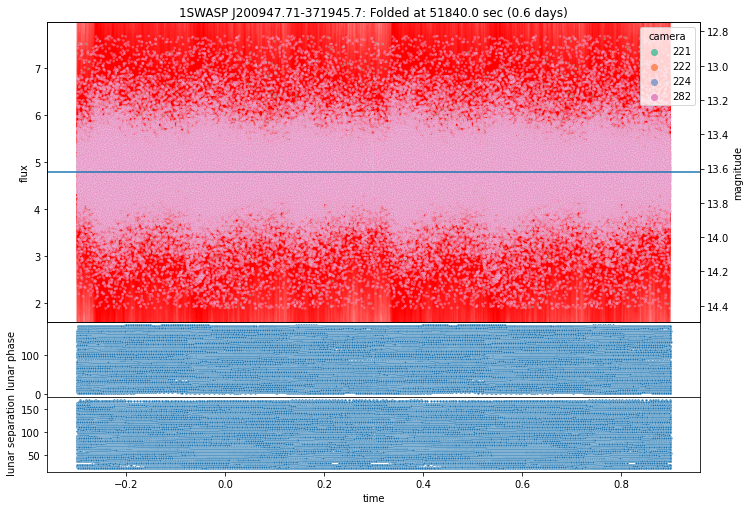

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\anm83\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


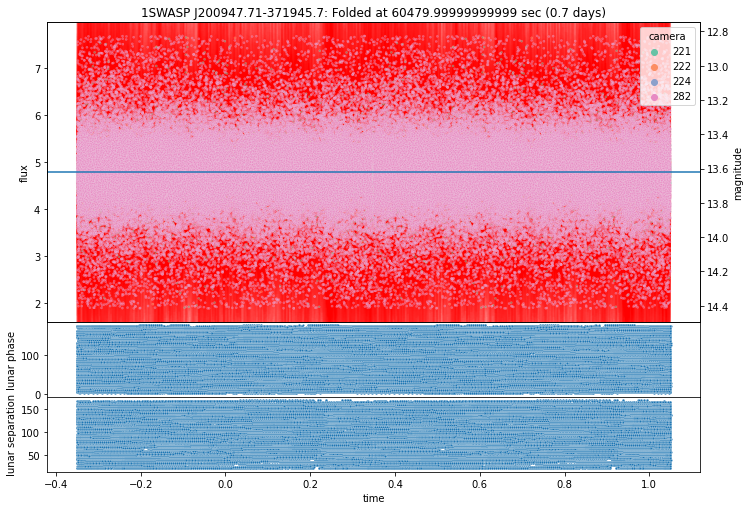

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\anm83\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


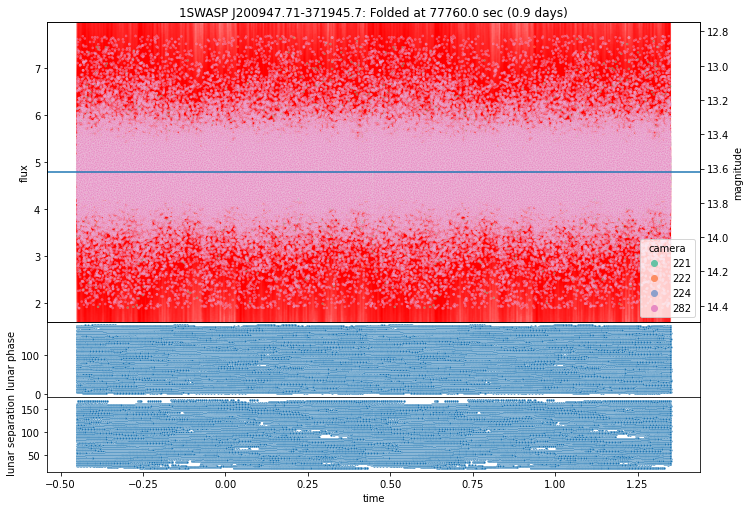

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


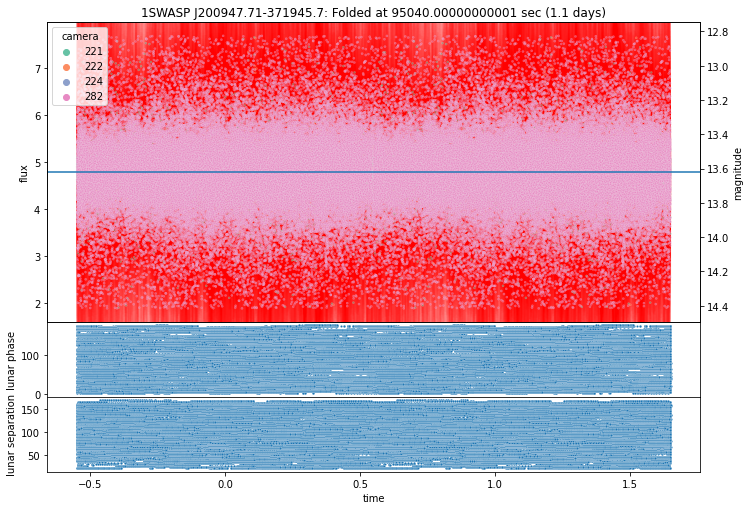

c:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\anm83\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


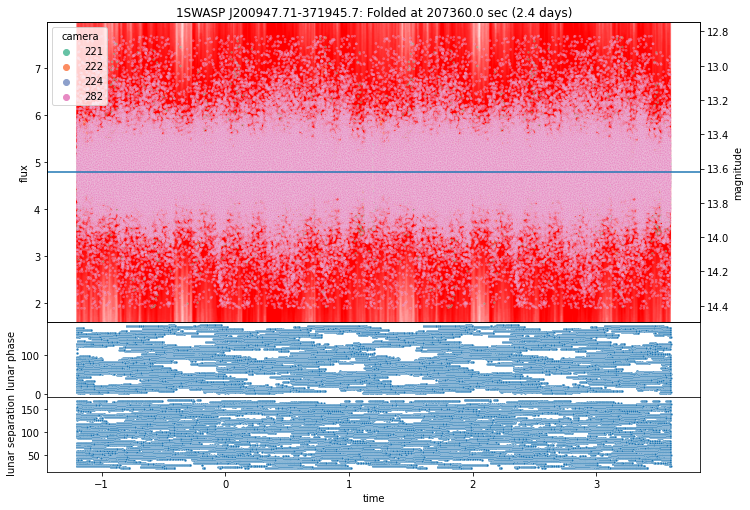

In [54]:
for i, period_row in periods.head(AUTO_FOLDED_PLOTS).iterrows():
    period = period_row['period']
    folded_ts_data = get_folded_ts(timeseries, period)

    f, (main_ax, lunar_phase_ax, lunar_sep_ax) = pyplot.subplots(
        3, 1, figsize=(11.7,8.27), sharex='col', gridspec_kw={'height_ratios': (4, 1, 1)}
    )

    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
        ax=main_ax,
    )

    lims = main_ax.get_ylim()
    main_ax.axhline(numpy.median(folded_ts_data['flux']))

    main_ax.errorbar(
        folded_ts_data['time'], folded_ts_data['flux'], yerr=folded_ts_data['err'], 
        ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1
    )

    main_ax.set_ylim(lims)
    main_ax_right = main_ax.twinx()
    try:
        main_ax_right.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
    except ValueError:
        pass
    main_ax_right.set_ylabel('magnitude')

    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='lunar phase',
        s=5,
        palette='Set2',
        ax=lunar_phase_ax,
    )

    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='lunar separation',
        s=5,
        palette='Set2',
        ax=lunar_sep_ax,
    )

    pyplot.subplots_adjust(hspace=.0)
    pyplot.title(f'{SWASP_ID}: Folded at {period * 86400} sec ({period} days)')
    pyplot.show()